# Evaluation of GRN inference methods
## Processing results
### by Jalil Nourisa



# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sys 
import numpy as np
import json
from scipy.stats import pearsonr
from pandas.api.types import CategoricalDtype
import seaborn
import matplotlib
from matplotlib.gridspec import  GridSpec
plt.rcParams['font.family'] = 'Arial' #Arial or 'Liberation Sans'
default_font = matplotlib.rcParams['font.family']
print(default_font)

# - add the src folder to the path
sys.path.insert(0, '../')
from src.helper import surragate_names, plot_heatmap, colors_blind, palette_celltype, palette_methods, DATASETS

# - set paths for task grn inference 
task_grn_inference_dir = '../../task_grn_inference'
results_folder = f'{task_grn_inference_dir}/resources/results'
scores_dir = f'{task_grn_inference_dir}/resources/scores'

# - displace order
category_order = CategoricalDtype(categories=['GRNBoost2', 'Scenic+', 'Pearson Corr.', 'Portia', 'PPCOR'], ordered=True)
metrics_category_order = CategoricalDtype(categories=['R1 (all)', 'R1 (grn)', 'R2 (precision)', 'R2 (balanced)', 'R2 (recall)'], ordered=True)

# - general settings

%matplotlib inline


['Arial']


In [2]:
def read_yaml_raw(file_path):
    import yaml
    with open(file_path, 'r') as file:
        yaml_content = yaml.safe_load(file)
    record_store = []
    for entry in yaml_content:
        dataset_id = entry['dataset_id']
        method_id = entry['method_id']
        metric_ids = entry['metric_ids']
        metric_values = entry['metric_values']
        for metric_id, metric_value in zip(metric_ids, metric_values):
            record_store.append({
                'dataset_id': dataset_id,
                'method_id': method_id,
                'metric_id': metric_id,
                'metric_value': metric_value
            })
    df = pd.DataFrame(record_store)
    
    return df
def pivot_table(df):
    df = df.pivot(index=['dataset_id', 'method_id'], columns='metric_id', values='metric_value').reset_index()
    df.rename(columns={'dataset_id': 'dataset', 'method_id': 'model'}, inplace=True)
    return df
def read_yaml(file_path):
    df = read_yaml_raw(file_path)
    df = pivot_table(df)
    return df

# Scores datasets

In [3]:
# !aws s3 sync s3://openproblems-data/resources/grn/results/ ../../task_grn_inference/resources/results/

In [4]:
if True:
    df1 = read_yaml_raw(f"{task_grn_inference_dir}/resources/results/scores_default_1/scores.yaml")
    df2 = read_yaml_raw(f"{task_grn_inference_dir}/resources/results/scores_default_2/scores.yaml")
    df3 = read_yaml_raw(f"{task_grn_inference_dir}/resources/results/scores_default_3/scores.yaml")
    df_all = pd.concat([df1, df2, df3])
    df_all = pivot_table(df_all)

if False:
    scores_path = f"{task_grn_inference_dir}/resources/results/scores_default/scores.yaml"
    df_all = read_yaml(scores_path)

if False:
    df_all = pd.read_csv(f"{task_grn_inference_dir}/resources/scores/scores_default.csv", index_col=0)
    df_all.index.name = 'model'

In [5]:
# - get the scores

df_all.index.name = ''
df_all.columns.name = ''
df_all.head()


,dataset,model,r1_all,r1_grn,r2-theta-0.0,r2-theta-0.5,r2-theta-1.0,ws-theta-0.0,ws-theta-0.5,ws-theta-1.0
,,,,,,,,,,
0,adamson,grnboost2,0.026202,0.043112,0.749756,0.680123,0.489601,0.893643,0.839474,0.731812
1,adamson,negative_control,-0.001914,-0.001914,0.579418,0.596753,0.448630,0.504262,0.511411,0.516267
2,adamson,pearson_corr,0.002799,0.004677,0.728282,0.647842,0.472361,0.857148,0.797870,0.662386
3,adamson,portia,0.020310,0.021040,0.562509,0.559324,0.447992,0.816194,0.672199,0.583006
4,adamson,positive_control,0.004782,0.011685,0.736031,0.649865,0.467088,0.633811,0.633970,0.610866


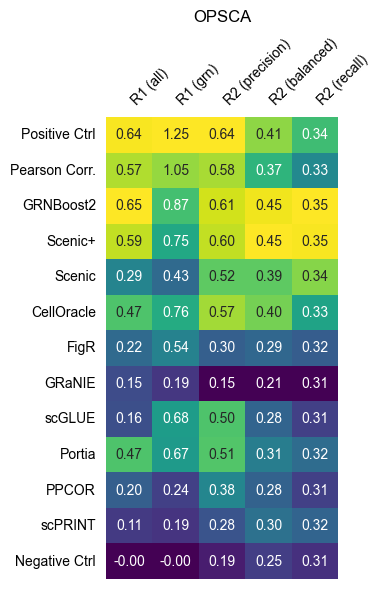

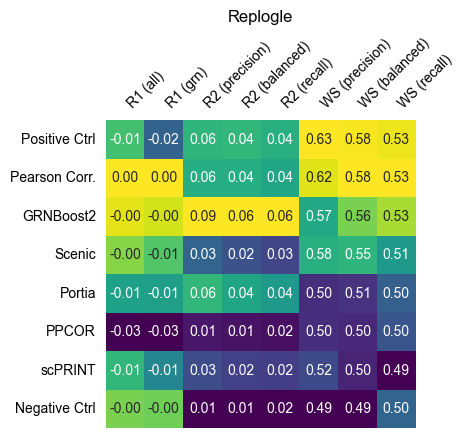

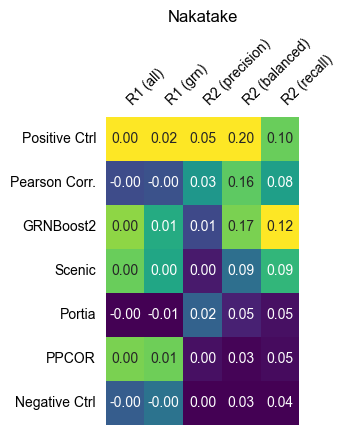

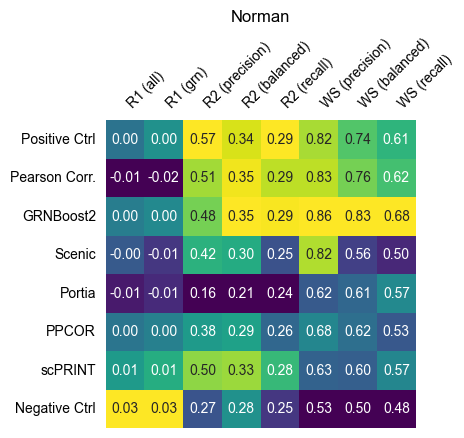

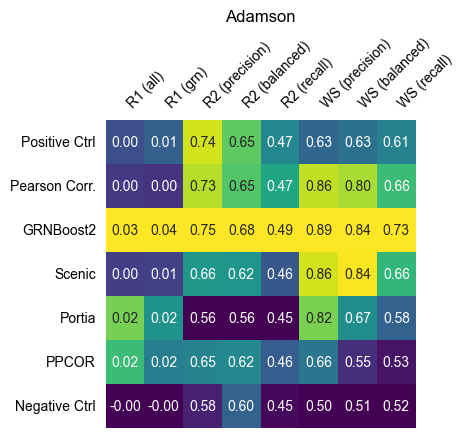

In [61]:
from src.helper import plot_heatmap, ORDERED_METHODS

def plot_raw_scores(df_all, dataset, ax):
    scores_mat = df_all[df_all['dataset'] == dataset]
    scores_mat = scores_mat.set_index('model').drop(columns='dataset')

    # Remove rows where all values are NaN
    scores_mat = scores_mat.dropna(how='all', axis=1)

    # Apply naming
    scores_mat.columns = scores_mat.columns.map(surragate_names)
    scores_mat.index = scores_mat.index.map(surragate_names)
    # Compute ranks and append as a new column
    # ranks = scores_mat.mean(axis=1).rank(ascending=False, method='min')
    # scores_mat['Rank'] = ranks

    # Sort by order
    available_methods = [method for method in ORDERED_METHODS if method in scores_mat.index]
    scores_mat = scores_mat.loc[available_methods]
    # Plot heatmap
    plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")

    ax.set_title(surragate_names.get(dataset, dataset), pad=10, fontsize=12)
    ax.set_ylabel('')

# Plot figures
for dataset in DATASETS:
    if dataset == 'op':
        figsize=(3, 6)
    else:
        figsize=(2.5, 4)
    if dataset in ['norman','adamson','replogle']:
        figsize=(4, 4)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    plot_raw_scores(df_all, dataset, ax)
    fig.savefig(f"{results_folder}/figs/raw_scores_{dataset}.png", dpi=300, transparent=True, bbox_inches='tight')


# Overview of performance

## Format resourcs used

In [8]:
if False: 
    job_ids_dict = { 
        'portia': 7751292,
        'grnboost2': 7747906,
        'scenic': 7748219,
        'ppcor': 7748321,
        'scglue': [7756286, 7756675],
        'scenicplus': [7761874, 7760439, 7760554],
        'figr': 7756664,
        'celloracle': 7761872,
        'pearson_corr': 7770044,
        'positive_control': 7770047,
        'negative_control':7770048 
    }
    
    df_res = process_trace_local(job_ids_dict)
    df_res = df_res[['Elapsed', 'MaxVMSize']]
    granie = pd.DataFrame({'Elapsed':  3643.337/60/60 * 24, 'MaxVMSize': 41},index=['granie'])
    df_res = pd.concat([df_res, granie], axis=0)
    df_res.columns = ['Duration (hour)', 'Peak memory (GB)']
    df_res.to_csv(f'{task_grn_inference_dir}/resources/results/trace.csv')
else:
    df_res = pd.read_csv(f'{task_grn_inference_dir}/resources/results/trace.csv', index_col=0)


## Merge scores with resources

In [9]:
# - read the scores
metrics = df_all.drop(['model', 'dataset'], axis=1).columns.values

In [10]:
# - s1 and s2 only for op 
df_store = []
for dataset in df_all['dataset'].unique():
    df_dataset = df_all[df_all['dataset']==dataset].copy()
    if dataset != 'op':
        df_dataset[['r1_grn', 'r1_all']] = np.nan
    df_store.append(df_dataset)
    
df_all_adj = pd.concat(df_store)

In [11]:
# - normalize the scores
def normalize_scores_per_dataset(df):
    df = df.set_index('model')
    df[df < 0] = 0
    df = (df-df.min(axis=0))/(df.max(axis=0)-df.min(axis=0))
    # df = df.rank(axis=0, ascending=False, method="min") 
    return df
df_all_n = df_all_adj.groupby('dataset').apply(normalize_scores_per_dataset).reset_index()


In [12]:
# - average scores for all datasets 
def mean_for_metrics(df):
    # Calculate mean across datasets for each metric, ignoring NaN values
    return df.drop(['dataset'], axis=1).mean(skipna=True)

df_metrics = (
    df_all_n.groupby(['model'])
    .apply(mean_for_metrics)
)
df_metrics

,r1_all,r1_grn,r2-theta-0.0,r2-theta-0.5,r2-theta-1.0,ws-theta-0.0,ws-theta-0.5,ws-theta-1.0
model,,,,,,,,
celloracle,0.718068,0.611809,0.857593,0.785095,0.576195,NaN,NaN,NaN
figr,0.335390,0.435786,0.304739,0.333618,0.293318,NaN,NaN,NaN
granie,0.226975,0.155449,0.000000,0.000000,0.000000,NaN,NaN,NaN
grnboost2,1.000000,0.696734,0.787823,0.956492,0.998468,0.867331,0.934401,0.957564
negative_control,0.000000,0.000000,0.087315,0.198094,0.062898,0.000000,0.000000,0.106084
pearson_corr,0.878308,0.841066,0.753392,0.747390,0.619582,0.915898,0.888967,0.793677
portia,0.717270,0.541042,0.339647,0.221606,0.185991,0.401950,0.322657,0.358325
positive_control,0.986997,1.000000,0.916171,0.835388,0.709178,0.734640,0.698156,0.687429
ppcor,0.302937,0.191347,0.310960,0.282854,0.176127,0.328084,0.201946,0.193808


In [13]:
# - average scores for all datasets 
def mean_for_datasets(df):
    # print(df.set_index('dataset')[metrics].T.mean(skipna=True))
    return df.set_index('dataset')[metrics].T.mean(skipna=True)

df_datasets = (
    df_all_n.groupby(['model'])
    .apply(mean_for_datasets)
    .reset_index()
)
df_datasets = df_datasets.pivot(index='model',columns='dataset',values=0)
df_datasets

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3116703261.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(mean_for_datasets)


dataset,adamson,nakatake,norman,op,replogle
model,,,,,
celloracle,NaN,NaN,NaN,0.709752,NaN
figr,NaN,NaN,NaN,0.340570,NaN
granie,NaN,NaN,NaN,0.076485,NaN
grnboost2,1.000000,0.673701,0.963005,0.922303,0.879648
negative_control,0.069245,0.000000,0.152568,0.082131,0.053042
pearson_corr,0.776850,0.615576,0.854703,0.741831,0.795269
portia,0.266806,0.147224,0.178645,0.551471,0.395266
positive_control,0.546719,0.922864,0.864949,0.902426,0.816771
ppcor,0.298239,0.026172,0.421740,0.291087,0.110281


## Calculate overal scores

In [14]:
# - calculate over scores
df_scores = pd.concat([df_metrics, df_datasets], axis=1)
# df_scores = df_metrics
df_scores['overall_score'] = df_scores.mean(axis=1, skipna=True)

# - merge scores with resources 
df_summary = pd.concat([df_scores, df_res], axis=1)
df_summary = df_summary.fillna(0)
df_summary.index.name = 'method_name' 
df_summary = df_summary.reset_index()

df_summary = df_summary.sort_values(by='overall_score', ascending=False) 
df_summary
df_summary.method_name = df_summary.method_name.map(surragate_names)
# - add user complexity 
df_summary['User-friendly'] = df_summary['method_name'].map({
                            'Scenic+': 1, 
                            'GRNBoost2': 8, 
                            'Positive Ctrl': 10, 
                            'Pearson Corr.': 10,
                            'CellOracle': 6,
                            'Portia': 9,
                            'scGLUE': 6,
                            'Scenic': 7,
                            'FigR': 6,
                            'PPCOR': 7,
                            'Negative Ctrl': 10,
                            'GRaNIE': 6,
                            'scPRINT': 5
                            })
df_summary['Complexity'] = df_summary['User-friendly'].max() - df_summary['User-friendly']
df_summary.columns = [surragate_names.get(col, col) for col in df_summary.columns]

df_summary= df_summary.fillna(0)
df_summary

,method_name,R1 (all),R1 (grn),R2 (precision),R2 (balanced),R2 (recall),WS (precision),WS (balanced),WS (recall),Adamson,Nakatake,Norman,OPSCA,Replogle,overall_score,Duration (hour),Peak memory (GB),User-friendly,Complexity
3,GRNBoost2,1.000000,0.696734,0.787823,0.956492,0.998468,0.867331,0.934401,0.957564,1.000000,0.673701,0.963005,0.922303,0.879648,0.895190,150.211111,7.378796,8,2
10,Scenic+,0.906689,0.604689,0.910277,1.000000,0.986145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.881560,0.000000,0.881560,234.811111,131.342854,1,9
7,Positive Ctrl,0.986997,1.000000,0.916171,0.835388,0.709178,0.734640,0.698156,0.687429,0.546719,0.922864,0.864949,0.902426,0.816771,0.817053,0.300000,11.601669,10,0
5,Pearson Corr.,0.878308,0.841066,0.753392,0.747390,0.619582,0.915898,0.888967,0.793677,0.776850,0.615576,0.854703,0.741831,0.795269,0.786347,0.827778,23.801899,10,0
0,CellOracle,0.718068,0.611809,0.857593,0.785095,0.576195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.709752,0.000000,0.709752,75.300000,41.601166,6,4
9,Scenic,0.449429,0.342807,0.463307,0.500715,0.441272,0.812153,0.608982,0.434923,0.649043,0.364819,0.446250,0.623635,0.433748,0.505468,480.172222,35.954300,7,3
11,scGLUE,0.239761,0.544760,0.715635,0.315179,0.194444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.401956,0.000000,0.401956,221.950000,61.677879,6,4
6,Portia,0.717270,0.541042,0.339647,0.221606,0.185991,0.401950,0.322657,0.358325,0.266806,0.147224,0.178645,0.551471,0.395266,0.355992,49.822222,55.685230,9,1
1,FigR,0.335390,0.435786,0.304739,0.333618,0.293318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.340570,0.000000,0.340570,134.633333,225.208725,6,4
12,scPRINT,0.168731,0.151688,0.439924,0.471631,0.391075,0.263764,0.198115,0.232160,0.000000,0.000000,0.569322,0.254374,0.154764,0.299595,0.000000,0.000000,5,5


## Summary figure

In [15]:
summary_file = f"{results_folder}/summary.tsv"
summary_figure = f"{results_folder}/summary_figure"

df_summary['memory_log'] = np.log(df_summary['Peak memory (GB)']+1)
df_summary['memory_log'] = np.max(df_summary['memory_log'])-df_summary['memory_log']

df_summary['complexity_log'] = np.log(df_summary['Complexity']+1)
df_summary['complexity_log'] = np.max(df_summary['complexity_log'])-df_summary['complexity_log']

df_summary["duration_log"] = np.log(df_summary['Duration (hour)']+1)
df_summary['duration_log'] = np.max(df_summary['duration_log'])-df_summary['duration_log']

df_summary["duration_str"] = df_summary['Duration (hour)'].round(1).astype(str)
df_summary['memory_str'] =  df_summary['Peak memory (GB)'].round(1).astype(str)

df_summary.to_csv(summary_file, sep='\t')

!Rscript ../src/summary_figure.R {summary_file} {summary_figure}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warnmeldung:
`thisfile()` was deprecated in rprojroot 2.0.0.
ℹ Please use `whereami::thisfile()` instead. 
New names:
• `` -> `...1`
Rows: 13 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): method_name
dbl (24): ...1, R1 (all), R1 (grn), R2 (precision), R2 (balanced), R2 (recal...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types 

# Scores: opsca, regression types, skelton

In [16]:
# from matplotlib.gridspec import GridSpec

    
# # Create a figure
# fig = plt.figure(figsize=(9, 6))
# gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 0.85, 1])
# axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

# dataset = 'op'
# for i, reg_type in enumerate(['ridge', 'GB']):
#     scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-{reg_type}-global-False.csv', index_col=0)
#     if 'collectri' in scores_mat.index:
#         scores_mat = scores_mat.drop('collectri')
#     scores_mat.columns = scores_mat.columns.map(surragate_names)
#     scores_mat.index = scores_mat.index.map(surragate_names)
#     scores_rank = scores_mat.rank(ascending=False).mean(axis=1)
#     # scores_mat['Rank'] = scores_rank.rank(ascending=True).astype(int)
    
#     ax = axes[i]
    
#     plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
#     if i != 0:
#         ax.set_yticklabels([])
#     ax.set_title(f"{surragate_names[dataset]} ({reg_type.capitalize() if not reg_type.isupper() else reg_type})", pad=10, fontsize=12)

# scores_mat_skeleton = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_True-binarize_False-ridge-global-False.csv', index_col=0)
# scores_mat_skeleton.columns = scores_mat_skeleton.columns.map(surragate_names)
# scores_mat_skeleton.index = scores_mat_skeleton.index.map(surragate_names)

# scores_rank = scores_mat_skeleton.div(scores_mat_skeleton.max(axis=0), axis=1).sum(axis=1)
# # scores_mat_skeleton['Rank'] = scores_rank.rank(ascending=False)

# ax = axes[2]
# plot_heatmap(scores_mat_skeleton, name='SLA normalization', ax=ax, cmap="viridis")
# ax.set_title(f"{surragate_names[dataset]} (Ridge)\n(Skeleton applied)", pad=10, fontsize=12)
# ax.set_yticklabels([])


# # fig.suptitle('(A) Regression scores (ridge)', y=1.2, fontsize=12, fontweight='bold')
# fig.savefig(f"{results_folder}/figs/evaluation_scores_opsca.png", dpi=300, transparent=True, bbox_inches='tight')

In [29]:
# # - skeleton vs normal
scores_mat_ridge = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv', index_col=0)
# scores_mat_GB = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-GB-global-False.csv', index_col=0)
scores_mat_skeleton = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_True-binarize_True-ridge-global-False.csv', index_col=0)

scores_mat_skeleton_n = scores_mat_skeleton/scores_mat_ridge
scores_mat_skeleton_n = scores_mat_skeleton_n.drop(['negative_control', 'scglue', 'granie', 'positive_control', 'celloracle', 'scenic', 'figr'])
def plot_skeleton_vs_nonskeleton(ax):
    scores_mat_n_all_long = scores_mat_skeleton_n.reset_index().melt(id_vars='index')
    
    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].map(surragate_names)
    

    scores_mat_n_all_long['variable'] = scores_mat_n_all_long['variable'].map(surragate_names)

    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].astype(category_order)
    # print(scores_mat_n_all_long)
    scores_mat_n_all_long.variable = scores_mat_n_all_long.variable.astype(metrics_category_order)
    sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(r'Relative R$^2$ scores')
    # ax.set_yscale('log')

    # Adjust margins and layout for the plot
    ax.margins(x=0.05)
    ax.margins(y=0.15)
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    ax.legend(title="Metric", loc=(1.05, .3), frameon=False)
# # fig, ax = plt.subplots(1, 1, figsize=(2.5, 2), sharey=False)
# # plot_skeleton_vs_nonskeleton(ax)
# # fig.savefig(f"{results_folder}/figs/skelton_guided_barplot.png", dpi=300, transparent=True, bbox_inches='tight')

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3964889533.py:15: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3964889533.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


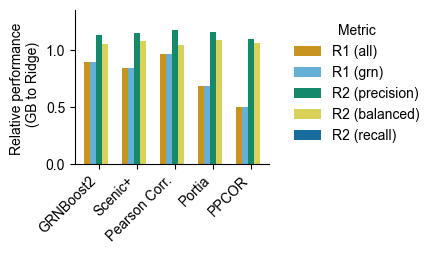

In [30]:
# - GB vs ridge
scores_mat_ridge = pd.read_csv(f'{scores_dir}/op/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv', index_col=0)
scores_mat_GB = pd.read_csv(f'{scores_dir}/op/X_norm-50000-skeleton_False-binarize_True-GB-global-False.csv', index_col=0)

scores_mat_n = scores_mat_GB/scores_mat_ridge
scores_mat_n = scores_mat_n.drop(['negative_control', 'scglue', 'granie', 'positive_control', 'celloracle', 'scenic', 'figr'])
def plot_gb_vs_ridge(ax):
    import seaborn as sns
    scores_mat_n_all_long = scores_mat_n.reset_index().melt(id_vars='index')
    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].map(surragate_names)
    scores_mat_n_all_long['variable'] = scores_mat_n_all_long['variable'].map(surragate_names)

    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].astype(category_order)
    scores_mat_n_all_long.variable = scores_mat_n_all_long.variable.astype(metrics_category_order)
    sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('Relative performance \n (GB to Ridge)')
    # ax.set_yscale('log')

    # Adjust margins and layout for the plot
    ax.margins(x=0.05)
    ax.margins(y=0.15)
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    ax.legend(title="Metric", loc=(1.1, .1), frameon=False)
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2), sharey=False)
plot_gb_vs_ridge(ax)
fig.savefig(f"{results_folder}/figs/gb_vs_ridge.png", dpi=300, transparent=True, bbox_inches='tight')

# Scores: global models

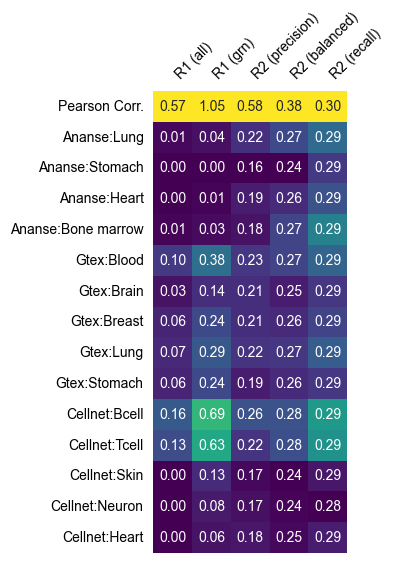

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(2.5, 6), sharey=False)
dataset='op'
ax = axes
scores_mat_o = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv', index_col=0)
scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-True.csv', index_col=0)
scores_mat = pd.concat([scores_mat_o.loc[['pearson_corr']], scores_mat])
scores_mat.columns = scores_mat.columns.map(surragate_names)
scores_mat.index = scores_mat.index.map(lambda name: surragate_names.get(name,name))


plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
# ax.set_title(f"{surragate_names[dataset]}\n(Global models)", pad=10, fontsize=12, fontweight='bold')
fig.savefig(f"{results_folder}/figs/evaluation_scores_global_models.png", dpi=300, transparent=True, bbox_inches='tight')

# Scores: pseduobulking

In [32]:

scores_mat = pd.read_csv(f'{results_folder}/metacells/scores_all.csv', index_col=0)
scores_mat.columns = scores_mat.columns.map(surragate_names)
scores_mat.index = scores_mat.index.map(lambda name: 'Original' if name == -1 else f'Metacell (res={name})')

index_oder = ['Original'] + [f'Metacell (res={name})' for name in range(19, 0, -2)]

# fig, ax = plt.subplots(1, 1, figsize=(3, 6), sharey=False)
# scores_mat = scores_mat.reindex(index=index_oder)
# plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
# ax.set_title(f"{surragate_names[dataset]}\n(Effect of pseudobulking)", pad=10, fontsize=12, fontweight='bold')
# fig.savefig(f"{results_folder}/figs/evaluation_scores_imputation.png", dpi=300, transparent=True, bbox_inches='tight')

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_line_pseudobulking_effect(ax):
    scores_mat = pd.read_csv(f'{results_folder}/metacells/scores_all.csv', index_col=0)
    scores_mat.columns = scores_mat.columns.map(surragate_names)
    scores_mat.index = scores_mat.index.map(lambda name: 'Original' if name == -1 else f'{name}')

    index_oder = ['Original'] + [f'{name}' for name in range(19, 0, -2)]

    scores_mat = scores_mat.reindex(index=index_oder)
    df_melted = scores_mat.reset_index().melt(id_vars='index', var_name='Method', value_name='Score')

    # Normalize the scores (divide by original for each metric)
    df_melted['Normalized Score'] = df_melted.groupby('Method')['Score'].transform(lambda x: x / x.iloc[0])

    # Remove the "Original" entry to only show the normalized scores
    df_melted = df_melted[df_melted['index'] != 'Original']

    # Plotting
    sns.lineplot(data=df_melted, x='index', y='Normalized Score', hue='Method', marker='o', ax=ax, palette=colors_blind)

    # Customize the plot
    ax.set_ylabel(r'Relative R$^2$ scores')
    ax.set_xlabel('Leiden resolution')
    
    # Rotate the x-axis labels
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

    # Remove top and right spines
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)

    # Adjust legend position
    ax.margins(y=0.15)
    ax.legend(title='Metric', loc=(1.05, .2), frameon=False)

# Example usage
# fig, ax = plt.subplots(1, 1, figsize=(2.5, 2), sharey=False)
# plot_line_pseudobulking_effect(ax)
# fig.savefig(f"{results_folder}/figs/evaluation_scores_imputation_lineplot.png", dpi=300, transparent=True, bbox_inches='tight')
# plt.tight_layout()
# plt.show()

# Scores: imputations

In [34]:

scores_mat_o = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv', index_col=0)
scores_mat = pd.read_csv(f'{results_folder}/imputation/scores_all.csv', index_col=0)
df_combined = pd.concat([ scores_mat_o.loc[['pearson_corr']], scores_mat.loc[['magic','knn']]], axis=0)
df_combined.index = ['Single-cell', 'Magic imput.','KNN imput.']
df_combined.columns = df_combined.columns.map(surragate_names)

# fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.7), sharey=False)

# plot_heatmap(df_combined, name='', ax=ax, cmap="viridis")
# ax.set_title(f"{surragate_names[dataset]}\n(Effect of imputation)", pad=10, fontsize=12, fontweight='bold')
# fig.savefig(f"{results_folder}/figs/evaluation_scores_imputation.png", dpi=300, transparent=True, bbox_inches='tight')

In [35]:
# Select the 'Single-cell' row for normalization
single_cell_row = df_combined.loc['Single-cell']

def plot_imput_vs_singlecell(ax):
    # Normalize all rows by dividing them by the 'Single-cell' row
    normalized_df = df_combined.div(single_cell_row, axis=1)
    normalized_df.drop('Single-cell', inplace=True)
    scores_mat_n_all_long = normalized_df.reset_index().melt(id_vars='index')
    # scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].map(surragate_names)
    # scores_mat_n_all_long['variable'] = scores_mat_n_all_long['variable'].map(surragate_names)

    # scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].astype(category_order)
    # scores_mat_n_all_long.variable = scores_mat_n_all_long.variable.astype(metrics_category_order)
    sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(r'Relative R$^2$ scores')
    # ax.set_yscale('log')

    # Adjust margins and layout for the plot
    ax.margins(x=0.05)
    ax.margins(y=0.15)
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    ax.legend(title="Metric", loc=(1.05, .3), frameon=False)
# fig, ax = plt.subplots(1, 1, figsize=(2, 2), sharey=False)
# plot_imput_vs_singlecell(ax)
# fig.savefig(f"{results_folder}/figs/imput_vs_singlecell.png", dpi=300, transparent=True, bbox_inches='tight')

# TF-guided inference

In [36]:
scores_mat = pd.read_csv(f'{results_folder}/causal_vs_corr/scores_all.csv', index_col=0)
print(scores_mat.columns)
scores_mat.columns = scores_mat.columns.map(lambda name: surragate_names[name] if name in surragate_names else name)
scores_mat['type'] = scores_mat['type'].map(lambda name: {'causal':'TF-masked correlation', 'corr':'Pure correlation'}.get(name,name))


# 
for i, dataset in enumerate(scores_mat.dataset.unique()):
    # ax = axes[i]
    scores_mat_sub = scores_mat[scores_mat.dataset==dataset].drop(columns='dataset')
    scores_mat_sub = scores_mat_sub.set_index(['type'])

    scores_mat_sub_n = scores_mat_sub.loc['TF-masked correlation'].div(scores_mat_sub.loc['Pure correlation'], axis=0).to_frame().T
    scores_mat_sub_n.index=[dataset]

    if dataset!='op':
        scores_mat_sub_n = scores_mat_sub_n[['R2 (precision)', 'R2 (balanced)', 'R2 (recall)']]

    if i == 0:
        scores_mat_n_all = scores_mat_sub_n
    else:
        scores_mat_n_all = pd.concat([scores_mat_n_all, scores_mat_sub_n]) 


Index(['r1_all', 'r1_grn', 'r2-theta-0.0', 'r2-theta-0.5', 'r2-theta-1.0',
       'type', 'dataset'],
      dtype='object')


In [37]:
def plot_tf_maked_versus_correlation(ax):
    scores_mat_n_all_long = scores_mat_n_all.reset_index().melt(id_vars='index')
    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].map(surragate_names)

    scores_mat_n_all_long.variable = scores_mat_n_all_long.variable.astype(metrics_category_order)
    sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(r'Relative R$^2$ scores (log)')
    ax.set_yscale('log')

    # Adjust margins and layout for the plot
    ax.margins(x=0.05)
    ax.margins(y=0.15)
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    ax.legend(title="Metric", loc=(1.05, .3), frameon=False)
# fig, ax = plt.subplots(1, 1, figsize=(2.5, 2), sharey=False)
# plot_tf_maked_versus_correlation(ax)
# fig.savefig(f"{results_folder}/figs/tf_guided_barplot.png", dpi=300, transparent=True, bbox_inches='tight')

# Combined plots

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/1877750601.py:21: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(data=df_melted, x='index', y='Normalized Score', hue='Method', marker='o', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3260401280.py:14: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3260401280.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


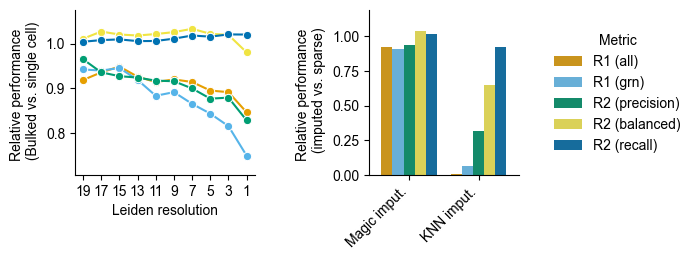

In [38]:
fig = plt.figure(figsize=(6, 2.2))
gs = fig.add_gridspec(1, 2)
i=0

ax = fig.add_subplot(gs[0, i]) 
plot_line_pseudobulking_effect(ax)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('Relative performance \n (Bulked vs. single cell)')
ax.get_legend().remove()
ax1=ax
i+=1

ax = fig.add_subplot(gs[0, i]) 
plot_imput_vs_singlecell(ax)
ax.get_legend().remove()
# ax.set_yticklabels([])
ax.set_ylabel('Relative performance \n (imputed vs. sparse)')
ax.margins(x=.1)
ax.spines[['right', 'top']].set_visible(False)
ax2=ax

plt.legend(loc=(1.2, .1), title='Metric', frameon=False)

ax1.set_position([0.01, 0.1, 0.3, 0.75])  
ax2.set_position([0.5, 0.1, 0.25, 0.75])  

fig.savefig(f"{results_folder}/figs/relative_scores_2.png", dpi=300, transparent=True, bbox_inches='tight')

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3874968491.py:6: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3874968491.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3605998960.py:19: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3605998960.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks

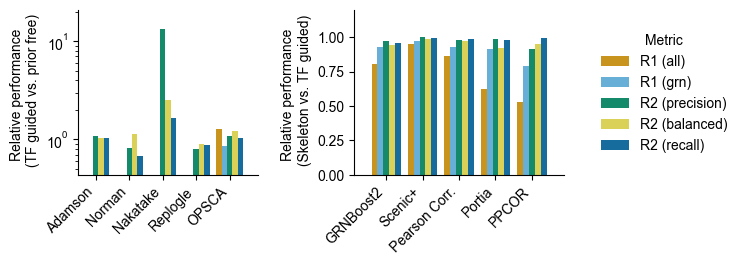

In [39]:
fig = plt.figure(figsize=(6, 2.2))
gs = fig.add_gridspec(1, 2)
i=0


ax = fig.add_subplot(gs[0, i]) 
plot_tf_maked_versus_correlation(ax)
ax.get_legend().remove()
ax.set_ylabel('Relative performance \n (TF guided vs. prior free)')
ax.spines[['right', 'top']].set_visible(False)
ax.margins(x=.1)
ax1=ax
i+=1


ax = fig.add_subplot(gs[0, i]) 
plot_skeleton_vs_nonskeleton(ax)
ax.get_legend().remove()
# ax.set_yticklabels([])
ax.margins(x=.1, y=.2)
ax.set_ylabel('Relative performance \n (Skeleton vs. TF guided)')


ax.spines[['right', 'top']].set_visible(False)
ax2=ax
i+=1


plt.legend(loc=(1.15, .1), title='Metric', frameon=False)

ax1.set_position([0.01, 0.1, 0.3, 0.75])  
ax2.set_position([0.47, 0.1, 0.35, 0.75])  

fig.savefig(f"{results_folder}/figs/relative_scores_3_4.png", dpi=300, transparent=True, bbox_inches='tight')

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3964889533.py:15: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3964889533.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3605998960.py:19: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/3605998960.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of tic

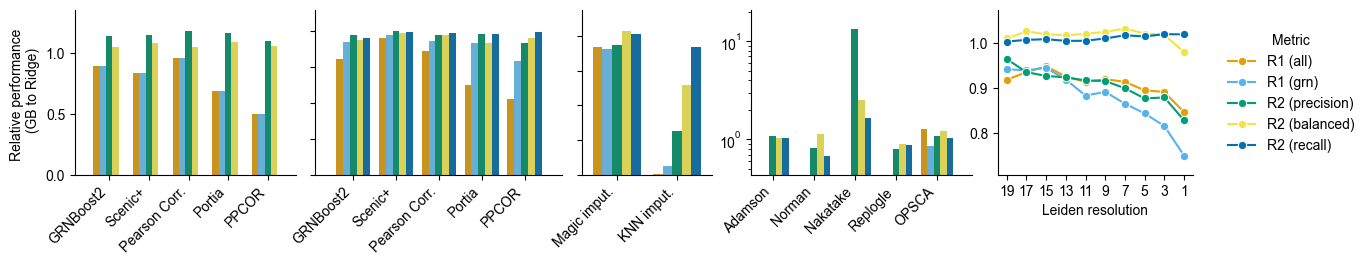

In [40]:
fig = plt.figure(figsize=(13, 2.2))
gs = fig.add_gridspec(1, 5)
i=0

ax = fig.add_subplot(gs[0, i]) 
plot_gb_vs_ridge(ax)
ax.get_legend().remove()
ax.margins(x=.1)
ax.spines[['right', 'top']].set_visible(False)
ax1=ax
i+=1

ax = fig.add_subplot(gs[0, i]) 
plot_skeleton_vs_nonskeleton(ax)
ax.get_legend().remove()
ax.set_yticklabels([])
ax.set_ylabel('')
ax.margins(x=.1)
ax.spines[['right', 'top']].set_visible(False)
ax2=ax
i+=1

ax = fig.add_subplot(gs[0, i]) 
plot_imput_vs_singlecell(ax)
ax.get_legend().remove()
ax.set_yticklabels([])
ax.set_ylabel('')
ax.margins(x=.1)
ax.spines[['right', 'top']].set_visible(False)
ax3=ax
i+=1

ax = fig.add_subplot(gs[0, i]) 
plot_tf_maked_versus_correlation(ax)
ax.set_ylabel('')
ax.get_legend().remove()
ax.spines[['right', 'top']].set_visible(False)
ax.margins(x=.1)
ax4=ax
i+=1

ax = fig.add_subplot(gs[0, i]) 
plot_line_pseudobulking_effect(ax)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('')
ax5=ax

plt.legend(loc=(1.15, .1), title='Metric', frameon=False)

ax1.set_position([0.01, 0.1, 0.17, 0.75])  
ax2.set_position([0.195, 0.1, 0.19, 0.75])  
ax3.set_position([0.4, 0.1, 0.1, 0.75])
ax4.set_position([0.53, 0.1, 0.17, 0.75]) 
ax5.set_position([0.72, 0.1, 0.15, 0.75]) 
fig.savefig(f"{results_folder}/figs/relative_scores_all.png", dpi=300, transparent=True, bbox_inches='tight')

# Robustness analysis

In [41]:
def format_robustness_results(base_dir, noise_type='net'):
    degrees = [0, 10, 20, 50, 100]
    reg1_metric = 'r1_all'
    reg2_metric = 'r2-theta-0.5'
    for i, degree in enumerate(degrees):
        df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
        df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
        df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
        
        if i == 0:
            reg1_scores = df_reg1
            reg2_scores = df_reg2
        else:
            reg1_scores = pd.concat([reg1_scores, df_reg1], axis=1)
            reg2_scores = pd.concat([reg2_scores, df_reg2], axis=1)
        
    reg1_scores = reg1_scores.T
    reg2_scores = reg2_scores.T
    return reg1_scores, reg2_scores

In [42]:
base_dir = f'{task_grn_inference_dir}/resources/results/robustness_analysis'
figsize=(3.5, 3)

noise_type = 'net'
reg1_mat_net, reg2_mat_net = format_robustness_results(base_dir, noise_type=noise_type)
noise_type = 'sign'
reg1_mat_sign, reg2_mat_sign = format_robustness_results(base_dir, noise_type=noise_type)
noise_type = 'weight'
reg1_mat_weight, reg2_mat_weight = format_robustness_results(base_dir, noise_type=noise_type)
noise_type = 'direction'
reg1_mat_direction, reg2_mat_direction = format_robustness_results(base_dir, noise_type=noise_type)

In [43]:
def merge_df(reg_mat_net, reg_mat_sign, reg_mat_weight, reg_mat_direction):
    reg_mat_net['Permute type'] = 'TF-gene link'
    reg_mat_sign['Permute type'] = 'TF-gene sign'
    reg_mat_weight['Permute type'] = 'TF-gene weight'
    reg_mat_direction['Permute type'] = 'TF-gene direction'
    df_concat = pd.concat([reg_mat_net, reg_mat_sign, reg_mat_weight, reg_mat_direction])
    df_concat = df_concat.drop(columns=['negative_control'])
    #  'scglue', 'granie', 'positive_control', 'celloracle', 'scenic', 'figr'
    df_concat.columns = df_concat.columns.map(lambda name: surragate_names.get(name, name))
    df_concat.reset_index().rename(columns={'index':'degree'}).melt(id_vars=['Permute type', 'degree'], var_name='model',value_name='r2score')
    df_concat = df_concat[~((df_concat['Permute type'] == 'TF-gene sign')&(df_concat.index == 100))]

    df_concat.columns.map(lambda name: surragate_names.get(name, name))

    # Reset the index so that noise degree remains a column
    df_concat.reset_index(inplace=True, drop=False)
    df_concat.rename(columns={'index': 'Degree'}, inplace=True)

    df_concat = df_concat.melt(id_vars=['Permute type', 'Degree'], var_name='model', value_name='r2score')


    
    # df_concat['model'] = df_concat['model'].astype(category_order)
    return df_concat


df_reg1 = merge_df(reg1_mat_net, reg1_mat_sign, reg1_mat_weight, reg1_mat_direction)
df_reg2 = merge_df(reg2_mat_net, reg2_mat_sign, reg2_mat_weight, reg2_mat_direction)


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_stacked_bar(df_all, ax, col='TF-gene connections'):
    
    def normalize(df):
        df = df.set_index('Degree')
        df['share'] = 0
        baseline = df.loc[0, 'r2score']
        for i, degree in enumerate(df.index):

            if degree == 0:
                share = 0
            else:
                share = 100*np.abs(df.loc[degree, 'r2score'] - baseline)/baseline
                df.loc[degree, 'share'] = share - previous_degree
                
            previous_degree = share
        
        return df
    df_all = df_all.groupby(['Permute type', 'model']).apply(normalize).reset_index(level='Degree').drop(columns='r2score')
    df_all['Degree'] = df_all['Degree'].astype('category')
    
    df = df_all[df_all['Permute type'] == col].drop(columns='Permute type')

    df.pivot(index='model', columns='Degree', values='share').plot(kind='bar', stacked=True,  ax=ax, color=palette_celltype)

    ax.get_legend().remove()
    ax.set_ylabel("R² score decline (%)")
    ax.set_xlabel("")
    ax.set_title(col, pad=12)
    ax.tick_params('x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'
        # plt.title("Drop in R² Score by Degree for Each Model")
    legend = ax.legend(title="Permutation\n   intensity", bbox_to_anchor=(1.05, 1), frameon=False)
def plot_line(df_all, ax, col='TF-gene connections'):
    
    def normalize(df):
        df = df.set_index('Degree')
        df['share'] = 0
        baseline = df.loc[0, 'r2score']
        for i, degree in enumerate(df.index):

            if degree == 0:
                share = 0
            else:
                share = 100*np.abs(df.loc[degree, 'r2score'] - baseline)/baseline
                df.loc[degree, 'share'] = share - previous_degree
                
            previous_degree = share
        
        return df
    df_all = df_all.groupby(['Permute type', 'model']).apply(normalize).reset_index(level='Degree').drop(columns='r2score')
    df_all['Degree'] = df_all['Degree'].astype('category')
    
    df = df_all[df_all['Permute type'] == col].drop(columns='Permute type')

    df_pivot = df.pivot(index='model', columns='Degree', values='share')
    for model in df_pivot.index:

        ax.plot(df_pivot.columns, df_pivot.loc[model], label=model, marker='o', color=palette_methods[model])

    ax.set_ylabel("R² score decline (%)")
    ax.set_xlabel("")
    ax.set_title(col, pad=12)
    ax.margins(x=.1)
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/148998546.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7685636903557532' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[degree, 'share'] = share - previous_degree
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/148998546.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.078843075026505' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[degree, 'share'] = share - previous_degree
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/148998546.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.690910341247823' has dtype incompatible with in

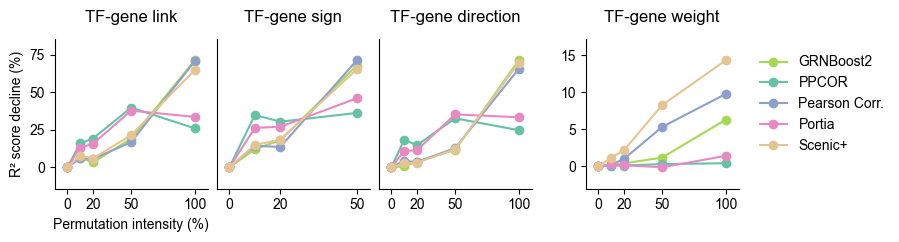

In [45]:

fig = plt.figure(figsize=(9, 2))

# Define the gridspec with uneven ratios for rows and columns
gs = fig.add_gridspec(1, 5)
df_reg1_short = df_reg1[df_reg1['model'].isin(['GRNBoost2', 'Scenic+', 'Pearson Corr.', 'Portia', 'PPCOR'])]

ax = fig.add_subplot(gs[0, 0]) 
plot_line(df_reg1_short, ax, col='TF-gene link')
ax.set_xlabel('Permutation intensity (%)')
ax.margins(y=.2)
ax.set_xticks([0, 20, 50, 100])

ax = fig.add_subplot(gs[0, 1]) 
plot_line(df_reg1_short, ax, col='TF-gene sign')
ax.set_ylabel('')
ax.set_yticks([])
ax.margins(y=.2)
# ax.set_xlim([-5,57])
ax.set_xticks([0, 20, 50])

ax = fig.add_subplot(gs[0, 2]) 
plot_line(df_reg1_short, ax, col='TF-gene direction')
ax.set_ylabel('')
ax.set_yticks([])
ax.margins(y=.2)
ax.set_xticks([0, 20, 50, 100])



ax = fig.add_subplot(gs[0, 3]) 
plot_line(df_reg1_short, ax, col='TF-gene weight')
ax.set_ylabel('')
ax.margins(y=.2)
ax.set_xticks([0, 20, 50, 100])
# ax.set_xscale('log')


legend = ax.legend(loc=(1.1, .2), frameon=False)

# Adjust positions for subplots in 2 rows
ax_list = fig.axes  # List of all axes

ax_list[0].set_position([0.01, 0.1, 0.17, 0.75])  
ax_list[1].set_position([0.19, 0.1, 0.17, 0.75])  
ax_list[2].set_position([0.37, 0.1, 0.17, 0.75])
ax_list[3].set_position([0.6, 0.1, 0.17, 0.75]) 

fig.savefig(f"{results_folder}/figs/robustnes_analysis.png", dpi=300, transparent=True, bbox_inches='tight') 

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/602849537.py:39: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/602849537.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/602849537.py:39: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_68459/602849537.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_684

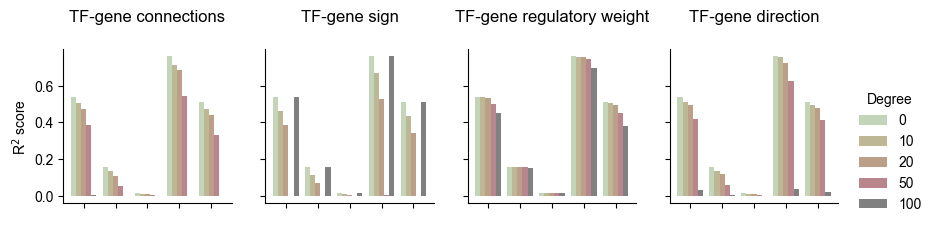

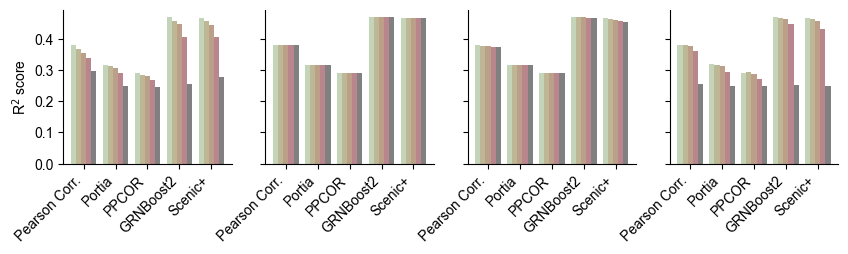

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_robustness(reg_mat_net, reg_mat_sign, reg_mat_weight, reg_mat_direction, axes):
    reg_mat_net['Permute type'] = 'TF-gene connections'
    reg_mat_sign['Permute type'] = 'TF-gene sign'
    reg_mat_weight['Permute type'] = 'TF-gene regulatory weight'
    reg_mat_direction['Permute type'] = 'TF-gene direction'

    # Concatenate the DataFrames
    df_concat = pd.concat([reg_mat_net, reg_mat_sign, reg_mat_weight, reg_mat_direction])
    df_concat = df_concat.drop(columns=['negative_control', 'scglue', 'granie', 'positive_control', 'celloracle', 'scenic', 'figr'])
    
    df_concat.columns = df_concat.columns.map(lambda name: surragate_names.get(name, name))

    # Reset the index so that noise degree remains a column
    df_concat.reset_index(inplace=True, drop=False)
    df_concat.rename(columns={'index': 'Degree'}, inplace=True)

    df_melt = pd.melt(df_concat, id_vars=['Degree', 'Permute type'], 
                    var_name='method', value_name=r'R$^2$ score')

    df_melt = df_melt[df_melt.method != 'Degree']

    # Create subplots for each 'Permute type'
    permute_types = df_melt['Permute type'].unique()
    

    if len(permute_types) == 1:
        axes = [axes]  # Ensure axes is always a list even if there's only one subplot

    for i, permute_type in enumerate(permute_types):
        ax = axes[i]
        # Filter data for the current 'Permute type'
        subset = df_melt[df_melt['Permute type'] == permute_type]

        # Create a bar plot for each subset
        sns.barplot(
            data=subset, 
            x='method', 
            y=r'R$^2$ score', 
            hue='Degree', 
            ax=ax, 
            palette=palette_celltype
        )

        # Rotate the x-axis labels and remove x-label
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')

        # Set the title for each subplot
        # ax.set_title(f'({chr(97 + i)}) {permute_type}', fontsize=12, pad=20)
        ax.set_title(f'{permute_type}', fontsize=12, pad=20)

        # Adjust margins and layout for the plot
        ax.margins(x=0.05)
        for side in ['right', 'top']:
            ax.spines[side].set_visible(False)
        ax.get_legend().remove()

    # Move the legend outside

    # plt.tight_layout()
    # plt.subplots_adjust(top=0.85)  # Adjust the top space for the suptitle
fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=True)
# Example usage:
plot_robustness(reg1_mat_net, reg1_mat_sign, reg1_mat_weight, reg1_mat_direction, axes)
# plt.suptitle('Permutation analysis, Regression 1', y=1.1, fontsize=14, fontweight='bold')
for ax in axes:
    ax.set_xticklabels([])
plt.legend(title="Degree", bbox_to_anchor=(1.05, .8), loc='upper left', frameon=False)


plt.savefig(f"{results_folder}/figs/robustness_reg1.png", dpi=300, transparent=True, bbox_inches='tight')
fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=True)
plot_robustness(reg2_mat_net, reg2_mat_sign, reg2_mat_weight, reg2_mat_direction, axes)
# plt.suptitle('Permutation analysis, Regression 2', y=1.1, fontsize=14, fontweight='bold')
for ax in axes:
    ax.set_title('')
# plt.subplots_adjust(
#     left=0.1,  # Space from the left edge of the figure
#     right=0.95,  # Space from the right edge of the figure
#     top=0.9,  # Space from the top of the figure
#     bottom=0.1,  # Space from the bottom of the figure
#     hspace=0.3,  # Height (vertical) space between rows
#     wspace=.3   # Width (horizontal) space between columns
# )

# plt.savefig(f"{results_folder}/figs/robustness_reg2.png", dpi=300, transparent=True, bbox_inches='tight')